# Initialization

In [1]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
os.environ["PYGAME_HIDE_SUPPORT_PROMPT"] = "hide"
import copy
import logging
import random
import matplotlib.pyplot as plt
import numpy as np
import torch
import tqdm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import tools
device = torch.device("cpu")

# Seeding

In [2]:
def seed_fn(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

# Create environments

* Create a 7x7 gridworld environment (similar to Gridworld A environment described in the ICL paper)
* Agent starts in one of the start states in `s`
* Agent terminates when it reaches cell $(6,0)$
* Maximum episode length can be 50

In [3]:
def create_env():
    r = np.zeros((7, 7))
    r[6, 0] = 1.0
    t = [(6, 0)]
    u = [(ui, uj) for ui in [3] for uj in [0, 1, 2, 3]]
    s = [(ui, uj) for ui in [0, 1, 2] for uj in [0, 1]]
    env = tools.environments.GridworldEnvironment(
        start_states=s,
        t=t,
        r=r,
        unsafe_states=u,
        stay_action=False,  # no action to "stay in current cell"
    )
    env = tools.environments.TimeLimit(env, 50)
    env = tools.environments.FollowGymAPI(env)
    env.seed(1)
    return env

# Visualization

In [4]:
def gridworld_imshow(m, fig, ax):
    m = np.array(m).squeeze()
    assert len(m.shape) == 2
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    im = ax.imshow(m, cmap="gray")
    # im.set_clim(0, 1)
    ax.set_xticks(np.arange(m.shape[0]))
    ax.set_yticks(np.arange(m.shape[1]))
    cbar = fig.colorbar(im, cax=cax)

In [5]:
def visualize_constraint(constraint_fn, fig=None, ax=None):
    global gridworld_dim, n_actions
    grid_for_action = []
    for a in np.arange(n_actions):
        grid = np.zeros((gridworld_dim, gridworld_dim))
        for x in np.arange(gridworld_dim):
            for y in np.arange(gridworld_dim):
                grid[x, y] = constraint_fn(([x, y], a))
        grid_for_action += [grid]
    average_grid = np.mean(grid_for_action, axis=0)
    if fig == None and ax == None:
        fig, ax = plt.subplots(1, 1, figsize=(3, 3))
    gridworld_imshow(average_grid, fig, ax)

In [6]:
def visualize_accrual(data, fig=None, ax=None):
    global gridworld_dim, n_actions
    accrual = np.array([np.zeros((gridworld_dim, gridworld_dim)) for _ in range(n_actions)])
    for S, A in data:
        for s, a in zip(S, A):
            x, y = s
            accrual[a][x][y] += 1
    accrual = np.mean(accrual, axis=0)
    accrual /= np.max(accrual)
    if fig == None and ax == None:
        fig, ax = plt.subplots(1, 1, figsize=(3, 3))
    gridworld_imshow(accrual, fig, ax)

# Constraint functions

Ground truth constraint function - $1$ in cells $\{(3,0), (3,1), (3,2), (3,3)\}$ and $0$ elsewhere

In [7]:
def true_constraint_function(sa):
    s, a = sa
    x, y = s[0], s[1]
    u = [(ui, uj) for ui in [3] for uj in [0, 1, 2, 3]]
    if (x, y) in u:
        return 1
    else:
        return 0

Current constraint function just uses the constraint neural network (input is state only for this example)

In [8]:
def current_constraint_function(sa):
    global constraint_nn, device
    s, a = sa
    return constraint_nn(torch.tensor(s, device=device, dtype=torch.float))  # Change this depending on the constraint_nn input

# PPO Penalty

Make policy and value networks for PPO:

In [9]:
def make_nn():
    global obs_n, act_n, hidden_dim, device
    value_nn = torch.nn.Sequential(
        torch.nn.Linear(obs_n, hidden_dim), torch.nn.ReLU(),
        torch.nn.Linear(hidden_dim, hidden_dim), torch.nn.ReLU(),
        torch.nn.Linear(hidden_dim, 1),
    ).to(device)
    policy_nn = torch.nn.Sequential(
        torch.nn.Linear(obs_n, hidden_dim), torch.nn.ReLU(),
        torch.nn.Linear(hidden_dim, hidden_dim), torch.nn.ReLU(),
        torch.nn.Linear(hidden_dim, act_n),
    ).to(device)
    return value_nn, policy_nn

Play an episode using the policy neural network and return states, actions, rewards and constraint values for the episode

In [10]:
def play_episode(env, policy_nn, constraint_fn):
    global device
    S, A, R, C = [], [], [], []
    S += [env.reset()]
    done = False
    while not done:
        probs = torch.nn.Softmax(dim=-1)(policy_nn(torch.tensor(S[-1], device=device, dtype=torch.float))).view(-1)
        action = np.random.choice(act_n, p=probs.cpu().detach().numpy())
        A += [action]
        next_state, reward, done, info = env.step(action)
        C += [constraint_fn((S[-1], action))]
        S += [next_state]
        R += [reward]
    return S, A, R, C

Convert $r_0, r_1, r_2, \cdots$ into $G_0, G_1, G_2, \cdots$ where $G_k = \sum_{t=k} \gamma^{t-k} r_t$

In [11]:
def discount(x, invert=False):
    global discount_factor
    n = len(x)
    g = 0
    d = []
    for i in range(n):
        if not invert:
            g = x[n - 1 - i] + discount_factor * g
            d = [g] + d
        else:
            g = g + x[i] * (discount_factor**i)
            d = d + [g]
    return d

PPO Replay Buffer:

In [12]:
class ReplayBuffer:
    def __init__(self, N):
        global obs_n, device
        self.N = N
        self.S = torch.zeros((self.N, obs_n), dtype=torch.float, device=device)
        self.A = torch.zeros((self.N), dtype=torch.long, device=device)
        self.G = torch.zeros((self.N), dtype=torch.float, device=device)
        self.log_probs = torch.zeros((self.N), dtype=torch.float, device=device)
        self.i = 0
        self.filled = 0

    def add(self, S, A, G, log_probs):
        M = S.shape[0]
        self.filled = min(self.filled + M, self.N)
        assert M <= self.N
        for j in range(M):
            self.S[self.i] = S[j, :]
            self.A[self.i] = A[j]
            self.G[self.i] = G[j]
            self.log_probs[self.i] = log_probs[j]
            self.i = (self.i + 1) % self.N

    def sample(self, n):
        global device
        minibatch = random.sample(range(self.filled), min(n, self.filled))
        S, A, G, log_probs = [], [], [], []
        for mbi in minibatch:
            s, a, g, lp = self.S[mbi], self.A[mbi], self.G[mbi], self.log_probs[mbi]
            S += [s]
            A += [a]
            G += [g]
            log_probs += [lp]
        return torch.stack(S), torch.stack(A), torch.stack(G), torch.stack(log_probs)

PPO Penalty Code (for algorithm, see ICL paper appendix):

In [13]:
def ppo_penalty(n_epochs, env, policy_nn, value_nn, constraint_fn, additional_fn_condition=None, additional_fn_epoch_end=None):
    # Additional function to be run when additional function condition is met
    # Additional function takes in current policy_nn and current iteration number
    global episodes_per_epoch, replay_buffer_size, learning_rate_feasibility, beta
    global ppo_subepochs, minibatch_size, learning_rate, device
    buffer = ReplayBuffer(replay_buffer_size)
    value_opt = torch.optim.Adam(value_nn.parameters(), lr=learning_rate)
    policy_opt = torch.optim.Adam(policy_nn.parameters(), lr=learning_rate)
    pbar = tqdm.notebook.tqdm(total=n_epochs)
    for epoch in range(n_epochs):
        S_e, A_e, G_e, Gc_e, Indices = [], [], [], [], []
        G0_e, Gc0_e = [], []
        max_cost_reached = 0.0
        max_cost_reached_n = 0
        S_e_buf, A_e_buf, G_e_buf = [], [], []
        for episode in range(episodes_per_epoch):
            S, A, R, C = play_episode(env, policy_nn, constraint_fn)
            start_index = len(A_e)
            S_e += S[:-1]  # ignore last state
            A_e += A
            G_e += discount(R)
            G0_e += [float(discount(R)[0])]
            Gc_e += discount(C)
            Gc0_e += [float(discount(C)[0])]
            end_index = len(A_e)
            Indices += [(start_index, end_index)]
            # Only add those experiences to replay buffer which are before the constraint violation
            inverted_discount = torch.tensor(discount(C, invert=True), dtype=torch.float, device=device)
            good_until = len(inverted_discount)
            for idx, item in enumerate(inverted_discount):
                if item >= beta:
                    good_until = idx + 1
                    break
            S_e_buf += S[:-1][:good_until]
            A_e_buf += A[:good_until]
            G_e_buf += discount(R[:good_until])
            if Gc0_e[-1] >= beta:
                max_cost_reached += 1
            max_cost_reached_n += 1
        pbar.set_description("Epoch %d:\tG_avg = %.2f\tGc_avg = %.2f\tMaxCostReached = %.2f"
            % (epoch, np.mean(G0_e), np.mean(Gc0_e), float(max_cost_reached / max_cost_reached_n)))
        S_e = torch.tensor(S_e, dtype=torch.float, device=device)
        A_e = torch.tensor(A_e, dtype=torch.long, device=device)
        G_e = torch.tensor(G_e, dtype=torch.float, device=device)
        Gc_e = torch.tensor(Gc_e, dtype=torch.float, device=device)
        S_e_buf = torch.tensor(S_e_buf, dtype=torch.float, device=device)
        A_e_buf = torch.tensor(A_e_buf, dtype=torch.long, device=device)
        G_e_buf = torch.tensor(G_e_buf, dtype=torch.float, device=device)
        log_probs_e_buf = torch.nn.LogSoftmax(dim=-1)(policy_nn(S_e_buf)).gather(1, A_e_buf.view(-1, 1)).view(-1)
        buffer.add(S_e_buf, A_e_buf, G_e_buf, log_probs_e_buf.detach())
        feasibility_opt = torch.optim.Adam(policy_nn.parameters(), lr=learning_rate_feasibility)
        # Penalty update on complete trajectories
        for start_index, end_index in Indices:
            Gc = Gc_e[start_index:end_index].view(-1)
            log_probs = torch.nn.LogSoftmax(dim=-1)(policy_nn(S_e[start_index:end_index])).gather(1, A_e[start_index:end_index].view(-1, 1)).view(-1)
            feasibility_opt.zero_grad()
            feasibility_loss = (Gc[0] >= beta) * ((Gc * log_probs).sum())
            feasibility_loss.backward()
            feasibility_opt.step()
        # Policy and value update from replay buffer
        for subepoch in range(ppo_subepochs):
            S, A, G, old_log_probs = buffer.sample(minibatch_size)
            log_probs = torch.nn.LogSoftmax(dim=-1)(policy_nn(S)).gather(1, A.view(-1, 1)).view(-1)
            value_opt.zero_grad()
            value_loss = (G - value_nn(S)).pow(2).mean()
            value_loss.backward()
            value_opt.step()
            policy_opt.zero_grad()
            advantages = G - value_nn(S)
            ratio = torch.exp(log_probs - old_log_probs)
            clipped_ratio = torch.clamp(ratio, 1 - clip_param, 1 + clip_param)
            policy_loss = -torch.min(ratio * advantages, clipped_ratio * advantages).mean()
            probs_all = torch.nn.Softmax(dim=-1)(policy_nn(S))
            log_probs_all = torch.nn.LogSoftmax(dim=-1)(policy_nn(S))
            entropy = -(probs_all * log_probs_all).sum(1).mean()
            policy_loss -= entropy_coef * entropy
            policy_loss.backward()
            policy_opt.step()
        # Run additional function at epoch end if condition is met
        # Just in case we need it for later! (and we will)
        if additional_fn_condition != None and additional_fn_epoch_end != None:
            if additional_fn_condition(epoch, policy_nn) == True:
                additional_fn_epoch_end(epoch, policy_nn)
        pbar.update(1)

* Collect $n$ trajectories using policy
* If `only_success` is True, then only return a set of trajectories that do not violate

In [14]:
def collect_trajectories(n, env, policy_nn, constraint_fn, only_success=False):
    data = []
    for traj in tqdm.notebook.tqdm(range(n)):
        S, A, R, C = play_episode(env, policy_nn, constraint_fn)
        while (not (discount(C)[0] <= beta)) and only_success:
            S, A, R, C = play_episode(test_env, policy_nn, constraint_fn)
        data += [[S[:-1], A]]
    return data

# Normalizing flow

Convert any set of trajectories to data which can be used to train the normalizing flow:

In [15]:
def convert_to_flow_data(data):
    global device
    flow_data = []
    for S, A in data:
        for s, a in zip(S, A):
            flow_data += [s]  # Change this depending on your constraint_nn input
    flow_data = torch.tensor(flow_data, dtype=torch.float, device=device)
    return flow_data

Compute trajectory dissimilarity w.r.t. expert NLL:

In [16]:
def dissimilarity_wrt_expert(data, mean=True):
    global flow, expert_nll, device
    expert_nll_mean, expert_nll_std = expert_nll
    sims = []
    for S, A in data:
        traj_data = S  # Change this depending on your constraint_nn input
        traj_data = torch.tensor(traj_data, dtype=torch.float, device=device)
        traj_nll = -flow.log_probs(traj_data).detach()
        sims += [(traj_nll > expert_nll_mean + expert_nll_std).float().mean()]
    if mean:
        return np.mean(sims)
    return torch.tensor(sims, dtype=torch.float, device=device)

# Constraint function adjustment

Collect a set of trajectories using a mixture of policies:

In [17]:
def collect_trajectories_mixture(n, env, policy_mixture, weights_mixture, constraint_fn):
    data = []
    value_nn, policy_nn = make_nn()
    normalized_weights_mixture = np.copy(weights_mixture) / np.sum(weights_mixture)
    m = len(weights_mixture)
    for traj in tqdm.notebook.tqdm(range(n)):
        chosen_policy_idx = np.random.choice(m, p=normalized_weights_mixture)
        policy_nn.load_state_dict(policy_mixture[chosen_policy_idx])
        S, A, R, C = play_episode(env, policy_nn, constraint_fn)
        data += [[S[:-1], A]]
    return data

Compute the discounted constraint value for each trajectory in a set of trajectories:

In [18]:
def compute_current_constraint_value_trajectory(constraint_nn, data):
    global device
    Gc0 = []
    for S, A in data:
        input_to_constraint_nn = []
        for s, a in zip(S, A):
            input_to_constraint_nn += [s]  # Change this depending on your constraint_nn input
        input_to_constraint_nn = torch.tensor(input_to_constraint_nn, dtype=torch.float, device=device)
        constraint_values = constraint_nn(input_to_constraint_nn).view(-1)
        Gc0 += [discount(constraint_values)[0]]
    return torch.stack(Gc0)

Constraint function adjustment:

In [19]:
def constraint_function_adjustment(n, constraint_nn, constraint_opt, expert_data, agent_data):
    global beta, alpha
    losses = []
    for _ in range(n):
        constraint_opt.zero_grad()
        per_traj_dissimilarity = dissimilarity_wrt_expert(agent_data, mean=False)
        per_traj_dissimilarity = per_traj_dissimilarity / per_traj_dissimilarity.sum()
        agent_data_constraint_returns = compute_current_constraint_value_trajectory(constraint_nn, agent_data)
        expert_data_constraint_returns = compute_current_constraint_value_trajectory(constraint_nn, expert_data)
        loss1 = -(agent_data_constraint_returns * per_traj_dissimilarity).sum()
        loss2 = ((expert_data_constraint_returns >= beta).float() * (expert_data_constraint_returns - beta)).mean()
        loss = loss1 + alpha * loss2
        loss.backward()
        constraint_opt.step()
        losses += [loss.item()]
    return np.mean(losses)

At the end of each PPO Penalty epoch, update dissimilarity and mixture weights if necessary:

In [20]:
def condition(epoch, policy_nn):
    if (epoch + 1) % policy_add_to_mix_every == 0:
        return True
    return False

In [21]:
def command(epoch, policy_nn):
    global policy_mixture, weights_mixture, agent_data
    global expert_data, test_env
    agent_data = collect_trajectories(len(expert_data), test_env, policy_nn, current_constraint_function)
    policy_mixture += [copy.deepcopy(policy_nn.state_dict())]
    weights_mixture += [dissimilarity_wrt_expert(agent_data)]
    print("Added policy with dissimilarity = %.2f" % weights_mixture[-1])

Generate expert data:

In [22]:
def generate_expert_data(env, only_success=False):  # use only_success if the policy isn't great and you just want to get optimal trajectories
    global ppo_iters, n_trajs
    value_nn, policy_nn = make_nn()
    ppo_penalty(ppo_iters, env, policy_nn, value_nn, true_constraint_function)
    expert_data = collect_trajectories(n_trajs, test_env, policy_nn, true_constraint_function, only_success=only_success)
    return expert_data

# Configuration

In [23]:
if __name__ == "__main__":
    seed_fn(1)
    gridworld_dim = 7
    n_actions = 8
    constraint_fn_input_dim = 2
    hidden_dim = 64
    env, test_env = create_env(), create_env()
    obs_n = env.observation_space.shape[0]
    act_n = env.action_space.n
    discount_factor = 1.0
    episodes_per_epoch = 20
    ppo_subepochs = 25
    replay_buffer_size = 10000
    learning_rate = 5e-4
    learning_rate_feasibility = 2.5e-5
    minibatch_size = 64
    clip_param = 0.1
    entropy_coef = 0.01
    beta = 0.99
    alpha = 15

In [24]:
if __name__ == "__main__":
    n_iters = 5
    flow_iters = 20
    ppo_iters = 500
    policy_add_to_mix_every = 250
    ca_iters = 20
    n_trajs = 50

# ICL

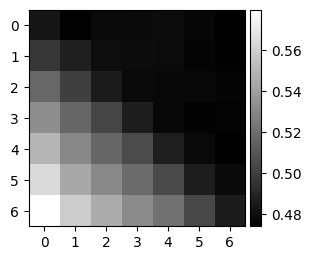

In [25]:
if __name__ == "__main__":
    constraint_nn = torch.nn.Sequential(
        torch.nn.Linear(constraint_fn_input_dim, hidden_dim), torch.nn.ReLU(),
        torch.nn.Linear(hidden_dim, hidden_dim), torch.nn.ReLU(),
        torch.nn.Linear(hidden_dim, 1), torch.nn.Sigmoid(),
    )
    constraint_opt = torch.optim.Adam(constraint_nn.parameters(), lr=learning_rate)
    visualize_constraint(current_constraint_function)

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

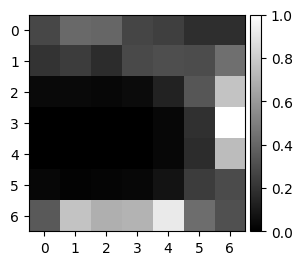

In [26]:
if __name__ == "__main__":
    expert_data = generate_expert_data(env)
    visualize_accrual(expert_data)

In [27]:
if __name__ == "__main__":
    flow_data = convert_to_flow_data(expert_data)
    flow_config = tools.data.Configuration({
        "normalize_flow_inputs": True,
        "minibatch_size": minibatch_size,
        "learning_rate": learning_rate,
    })
    flow_config["t"].device = device
    flow = tools.functions.create_flow(flow_config, flow_data, "realnvp", constraint_fn_input_dim)
    for flowepoch in range(flow_iters):
        metrics = flow.train()
        print(metrics)
    nll = -flow.log_probs(flow_data)
    expert_nll = (nll.mean(), nll.std())

{'avg_nll': 2.24755309178279, 'std_nll': 0.14424446043900727}
{'avg_nll': 2.066843908566695, 'std_nll': 0.08905543378543862}
{'avg_nll': 1.9754672646522522, 'std_nll': 0.07425115636972114}
{'avg_nll': 1.867663167990171, 'std_nll': 0.1071869789911104}
{'avg_nll': 1.686857397739704, 'std_nll': 0.10720399854009736}
{'avg_nll': 1.454549592274886, 'std_nll': 0.1454145007086213}
{'avg_nll': 1.2890073565336375, 'std_nll': 0.1241290860548404}
{'avg_nll': 1.144765936411344, 'std_nll': 0.18100003533605957}
{'avg_nll': 1.1555754840373993, 'std_nll': 0.5734541329946926}
{'avg_nll': 1.4207507555301373, 'std_nll': 0.1951595117079672}
{'avg_nll': 1.1500869324574103, 'std_nll': 0.16274897487443293}
{'avg_nll': 0.9985516163019034, 'std_nll': 0.2507731558283449}
{'avg_nll': 1.21943687246396, 'std_nll': 0.23286599721598253}
{'avg_nll': 1.0024722172663763, 'std_nll': 0.16273307826036715}
{'avg_nll': 0.8999180885461661, 'std_nll': 0.42540828668531366}
{'avg_nll': 1.0993613600730896, 'std_nll': 0.2732414482

Expert satisfaction = 0.00
ICL iteration 0 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Added policy with dissimilarity = 0.58


  0%|          | 0/50 [00:00<?, ?it/s]

Added policy with dissimilarity = 0.60


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

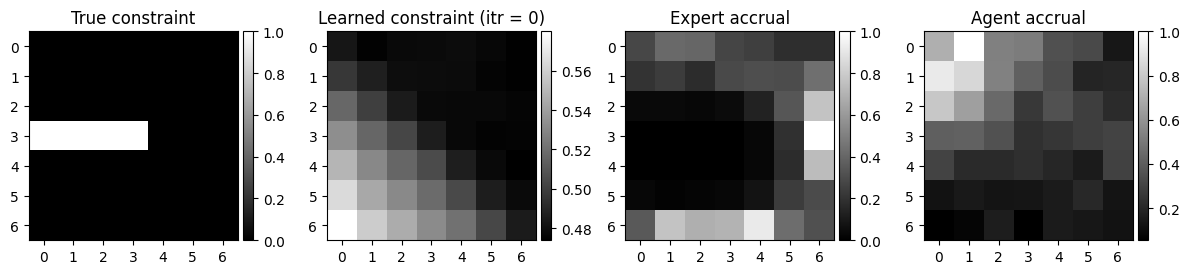

  0%|          | 0/20 [00:00<?, ?it/s]

Expert satisfaction = 0.90
ICL iteration 1 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Added policy with dissimilarity = 0.68


  0%|          | 0/50 [00:00<?, ?it/s]

Added policy with dissimilarity = 0.72


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

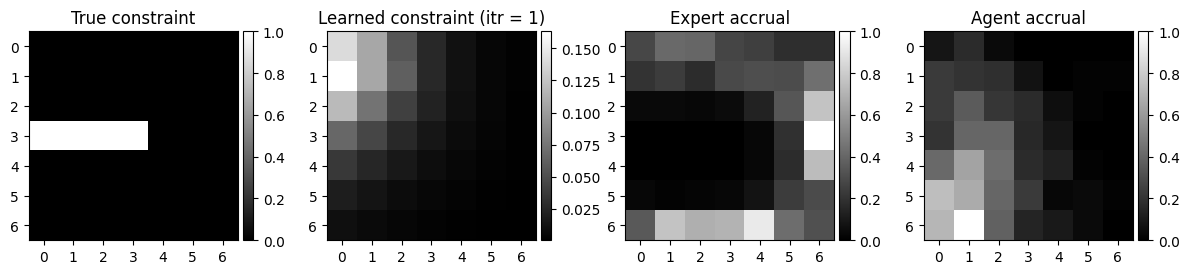

  0%|          | 0/20 [00:00<?, ?it/s]

Expert satisfaction = 0.90
ICL iteration 2 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Added policy with dissimilarity = 0.52


  0%|          | 0/50 [00:00<?, ?it/s]

Added policy with dissimilarity = 0.62


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

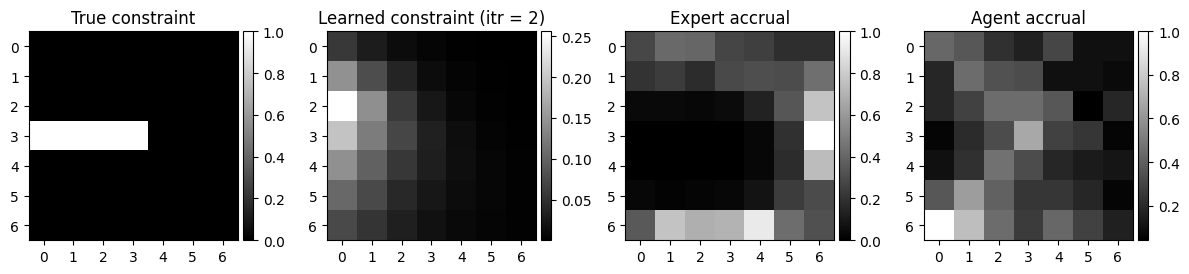

  0%|          | 0/20 [00:00<?, ?it/s]

Expert satisfaction = 0.88
ICL iteration 3 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Added policy with dissimilarity = 0.35


  0%|          | 0/50 [00:00<?, ?it/s]

Added policy with dissimilarity = 0.28


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

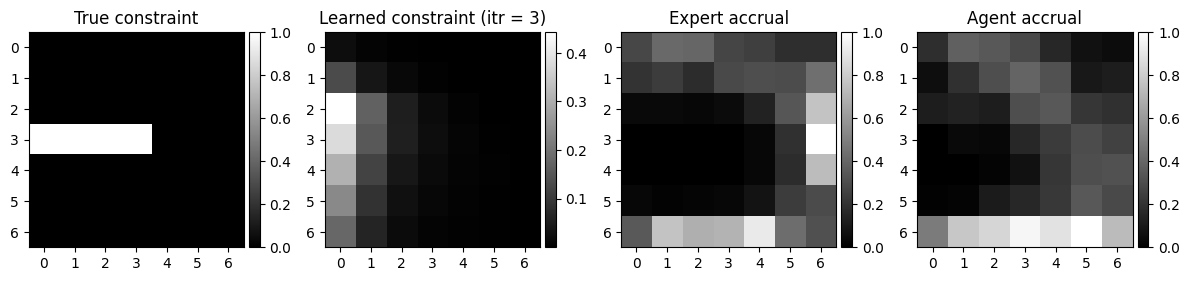

  0%|          | 0/20 [00:00<?, ?it/s]

Expert satisfaction = 0.84
ICL iteration 4 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Added policy with dissimilarity = 0.46


  0%|          | 0/50 [00:00<?, ?it/s]

Added policy with dissimilarity = 0.19


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

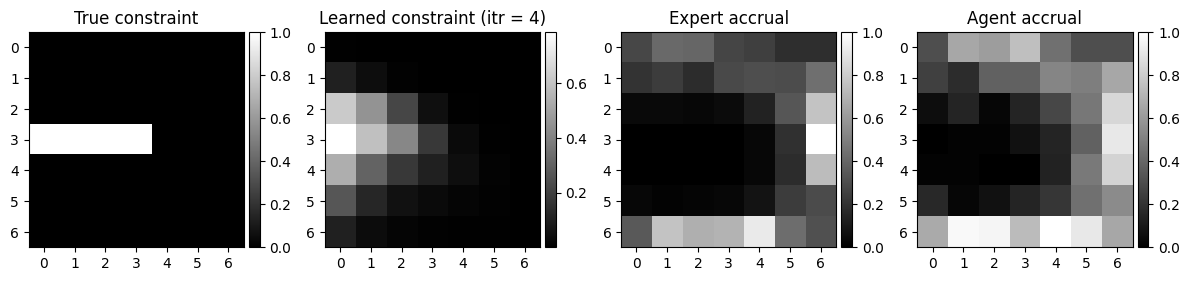

  0%|          | 0/20 [00:00<?, ?it/s]

Expert satisfaction = 0.80


In [28]:
if __name__ == "__main__":
    policy_mixture, weights_mixture = [], []
    expert_satisfaction = (compute_current_constraint_value_trajectory(constraint_nn, expert_data) <= beta).float().mean()
    print("Expert satisfaction = %.2f" % expert_satisfaction)
    for itr in range(n_iters):
        print("ICL iteration %d ..." % itr)
        value_nn, policy_nn = make_nn()
        ppo_penalty(ppo_iters, env, policy_nn, value_nn, current_constraint_function, condition, command)
        agent_data = collect_trajectories(len(expert_data), test_env, policy_nn, current_constraint_function)
        mixture_data = collect_trajectories_mixture(len(expert_data), test_env, policy_mixture, weights_mixture, current_constraint_function)
        fig, ax = plt.subplots(1, 4, figsize=(12, 3))
        visualize_constraint(true_constraint_function, fig, ax[0])
        ax[0].set_title("True constraint")
        visualize_constraint(current_constraint_function, fig, ax[1])
        ax[1].set_title("Learned constraint (itr = %d)" % itr)
        visualize_accrual(expert_data, fig, ax[2])
        ax[2].set_title("Expert accrual")
        visualize_accrual(agent_data, fig, ax[3])
        ax[3].set_title("Agent accrual")
        fig.tight_layout()
        plt.show()
        mixture_data_constraint_returns = compute_current_constraint_value_trajectory(constraint_nn, mixture_data)
        for _ in tqdm.notebook.tqdm(range(ca_iters)):
            constraint_function_adjustment(ca_iters, constraint_nn, constraint_opt, expert_data, mixture_data)
        expert_satisfaction = (compute_current_constraint_value_trajectory(constraint_nn, expert_data) <= beta).float().mean()
        print("Expert satisfaction = %.2f" % expert_satisfaction)

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

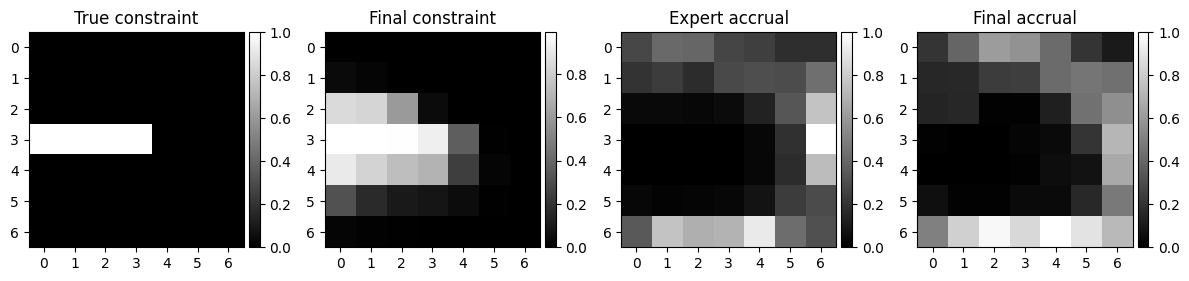

In [29]:
if __name__ == "__main__":
    value_nn, policy_nn = make_nn()
    ppo_penalty(ppo_iters, env, policy_nn, value_nn, current_constraint_function)
    agent_data = collect_trajectories(len(expert_data), test_env, policy_nn, current_constraint_function)
    fig, ax = plt.subplots(1, 4, figsize=(12, 3))
    visualize_constraint(true_constraint_function, fig, ax[0])
    ax[0].set_title("True constraint")
    visualize_constraint(current_constraint_function, fig, ax[1])
    ax[1].set_title("Final constraint")
    visualize_accrual(expert_data, fig, ax[2])
    ax[2].set_title("Expert accrual")
    visualize_accrual(agent_data, fig, ax[3])
    ax[3].set_title("Final accrual")
    fig.tight_layout()
    plt.show()